# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

# `Занятие 06. Дополнительные Главы PyTorch`

## `Занятие провел: Феоктистов Дмитрий (@trandelik)`

## `Материалы составил: Феоктистов Дмитрий (@trandelik)`

### `Москва, Весенний семестр 2026`

Источники:

- [1] **Network Sparsity and Reinforcement Learning**: [Guozheng Ma et al., 2025], 5 цитат
- [2] **Pruning and Generalization**: [Tian Jin et al., 2022], 47 цитат
- [3] О возможностях Sparse Neural Networks: [Qiao Xiao et al., 2024](https://arxiv.org/abs/2409.09196), 2 цитаты
- [Документация torch distributions](https://docs.pytorch.org/docs/stable/distributions.html)

О чём можно узнать из этого ноутбука:

* Как написать свой оптимизатор в PyTorch
* Продвинутая работа с тензорами (индексая, Эйнштейновская нотация, как работает reshape)
* Продвинутая работа с модулями (инициализация, параметризации)
* Как работать с распределениями в PyTorch
* Как использовать Forward Mode Differentiation
* Несколько способов, как выстрелить себе в ногу

In [ ]:
%config Completer.use_jedi = False # чтобы автодополнение с помощью табов работало

import torch

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

---

## Оптимизация в PyTorch

Мы знаем, как считать в PyTorch градиенты, а еще мы знаем, что для обучения нейронных сетей нужно решать задачу оптимизации. Давайте научимся решать оптимизационную задачу на PyTorch, а уже в следующий раз разберем, как именно решать оптимизационную задачу для обучения

In [ ]:
def rosenbrock(x, a=1, b=100):
    return torch.sum((a - x[:-1]) ** 2 + b * (x[1:] - x[:-1] ** 2) ** 2)

Это функция Розенброка, на ней часто тестируют методы оптимизации, ее глобальный оптимум &ndash; вектор из всех единиц

In [ ]:
num_iters = 10000
dim = 5

x = torch.full((dim, ), 1/ dim, requires_grad=True)
lr = 3e-4

values = []

for i in range(num_iters):
    value = rosenbrock(x)
    value.backward()

    with torch.no_grad():
        x.data = x.data - lr * x.grad
    x.grad = None
    values.append(value.item())

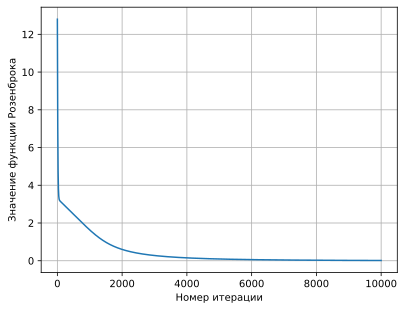

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']


plt.plot(torch.arange(num_iters), values)
plt.grid(True)
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции Розенброка')
plt.show()

In [ ]:
x

tensor([0.9875, 0.9752, 0.9509, 0.9039, 0.8165], requires_grad=True)

А что если нам понадобится написать сложный оптимизатор, хотя бы Адам? Придется все делать руками? А если параметров много? То плодить циклы? К счастью, нет, в PyTorch есть отдельный модуль, который отвечает за оптимизаторы. Посмотрим, как работать с ними

In [ ]:
from torch import optim

In [ ]:
x = torch.full((dim, ), 1/ dim, requires_grad=True)
optimizer = optim.SGD([x], lr=lr)

values_pt = []

for i in range(num_iters):
    value = rosenbrock(x)
    value.backward()
    optimizer.step()
    optimizer.zero_grad()
    values_pt.append(value.item())

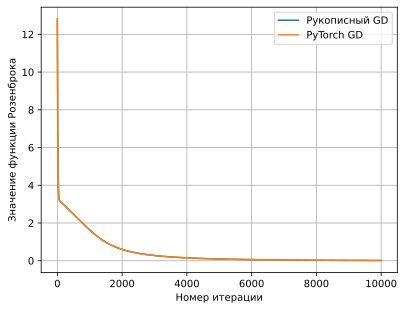

In [ ]:
plt.plot(torch.arange(num_iters), values, label='Рукописный GD')
plt.plot(torch.arange(num_iters), values_pt, label='PyTorch GD')
plt.grid(True)
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции Розенброка')
plt.legend()
plt.show()

In [ ]:
x = torch.full((dim, ), 1/ dim, requires_grad=True)
optimizer = optim.Adam([x], lr=lr)

values_adam = []

for i in range(num_iters):
    value = rosenbrock(x)
    value.backward()
    optimizer.step()
    optimizer.zero_grad()
    values_adam.append(value.item())

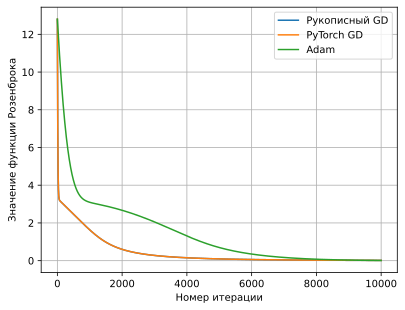

In [ ]:
plt.plot(torch.arange(num_iters), values, label='Рукописный GD')
plt.plot(torch.arange(num_iters), values_pt, label='PyTorch GD')
plt.plot(torch.arange(num_iters), values_adam, label='Adam')
plt.grid(True)
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции Розенброка')
plt.legend()
plt.show()

Однако `torch.optim` содержит далеко не все оптимизаторы, и это может быть неприятно. Как тогда написать свой?

In [ ]:
class Signum(optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.09, weight_decay=0, **kwargs):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)

        super(Signum, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Signum, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(p.data, alpha=weight_decay)
                if momentum != 0:
                    # signum
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)

                    else:
                        buf = param_state['momentum_buffer']

                    buf.mul_(momentum).add_(d_p, alpha=(1 - momentum))
                    d_p = torch.sign(buf)
                else:#signsgd
                    d_p = torch.sign(d_p)

                p.data.add_(d_p, alpha=-group['lr'])

        return loss

In [ ]:
x = torch.full((dim, ), 1/ dim, requires_grad=True)
optimizer = Signum([x], lr=lr)

values_signum = []

for i in range(num_iters):
    value = rosenbrock(x)
    value.backward()
    optimizer.step()
    optimizer.zero_grad()
    values_signum.append(value.item())

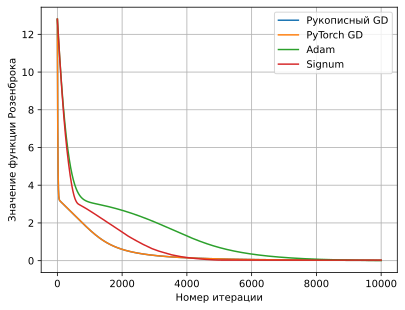

In [ ]:
plt.plot(torch.arange(num_iters), values, label='Рукописный GD')
plt.plot(torch.arange(num_iters), values_pt, label='PyTorch GD')
plt.plot(torch.arange(num_iters), values_adam, label='Adam')
plt.plot(torch.arange(num_iters), values_signum, label='Signum')
plt.grid(True)
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции Розенброка')
plt.legend()
plt.show()

Вы могли заметить, что мы везде для получения `lr` и `momentum` использовали group. Зачем такое может быть нужно? Это дает возможность разбить параметры вашей модели на группы и использовать разные параметры оптимизатора для каждого из тензоров. Иногда это может помочь лучше обучить модель. Разберем игрушечный пример.

In [ ]:
x = torch.full((dim, ), 1/ dim, requires_grad=True)
z = torch.full((dim, ), 0.2/ dim, requires_grad=True)
optimizer = optim.SGD([x, z], lr=lr)

values = []

for i in range(num_iters):
    value = rosenbrock(x * z ** 2)
    value.backward()
    optimizer.step()
    optimizer.zero_grad()
    values.append(value.item())

print(f"Минимальное найденное значение псевдо функции Розенброка: {min(values)}")

Минимальное найденное значение псевдо функции Розенброка: 3.4251976013183594


In [ ]:
x = torch.full((dim, ), 1/ dim, requires_grad=True)
z = torch.full((dim, ), 0.2/ dim, requires_grad=True)
optimizer = optim.SGD([
    {'params': x},
    {'params': z, 'lr': 1e-3}
], lr=lr)

values = []

for i in range(num_iters):
    value = rosenbrock(x * z ** 2)
    value.backward()
    optimizer.step()
    optimizer.zero_grad()
    values.append(value.item())

print(f"Минимальное найденное значение псевдо функции Розенброка: {min(values)}")

Минимальное найденное значение псевдо функции Розенброка: 1.1358027458190918


Ну и наконец, осталось разобрать, что же такое `closure`. Тут все просто &ndash; некоторые методы могут хотеть считать градиент не в той точке, в которой находится модель сейчас, или же считать их несколько раз за итерацию. Для обеспечения подобной возможности и используется `closure` &ndash; она просто считает градиенты модели (в текущем батче). Также вы можете туда положить какую-то свою логику. То есть это просто инструмент для обеспечения гибкости

In [ ]:
x = torch.full((dim, ), 1/ dim, requires_grad=True)
optimizer = optim.SGD([x], lr=lr)

values = []

for i in range(num_iters):
    def closure():
        optimizer.zero_grad()
        value = rosenbrock(x)
        value.backward()
        return value
    value = optimizer.step(closure)
    values.append(value.item())

print(f"Минимальное найденное значение функции Розенброка: {min(values)}")

Минимальное найденное значение функции Розенброка: 0.012463781051337719


## Продвинутая работа с тензорами

### View vs Reshape

Тензор &ndash; это только обертка над непрерывным куском памяти, содержащая разные метаданные (например, размерность, stride). Когда мы хотим посмотреть на данный тензор, как на тензор другой размерности, то у нас появляются две опции:

- `.view()`: Пытается создать новую обертку над той же самой областью памяти. Это очень быстро (O(1)), но требует, чтобы данные лежали в памяти последовательно (contiguous) **согласно новой размерности**.
- `.reshape()`: "Умный" метод. Если можно сделать view, он делает view. Если нельзя (данные в памяти перемешаны, например, после транспонирования) &ndash; он копирует данные в новый кусок памяти (делает `.clone()`) и возвращает результат. Это безопаснее, но может скрыто ударить по производительности.

Зачем же тогда нужен `.view()`?

- `reshape()` может молча скопировать данные. Представьте, что вы работаете с огромным тензором, который занимает 4 ГБ видеопамяти. Если вы напишете `.reshape()` на неконтигуальном тензоре, PyTorch молча выделит еще 4 ГБ памяти и скопирует туда данные. Что может вызвать OOM и испортить жизнь соседу по видеокарте, в то время как `.view()` упадет
- Часто ошибка `RuntimeError: input is not contiguous` при вызове `.view()` сигнализирует о том, что вы запутались в размерностях. В то время как `.reshape()` переварит вашу ошибку
- Когда вы видите в чужом коде `x.view(...)`, вы точно знаете, что тут меняется только интерпретация размерностей, данные остаются на месте.


In [ ]:
# Создадим тензор
t = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(f"Исходный тензор:\n{t}")
print(f"Is contiguous? {t.is_contiguous()}")

# Транспонируем. В памяти данные всё ещё лежат как [1, 2, 3, 4, 5, 6],
# но stride (шаг) изменился, чтобы мы читали их как [[1, 4], [2, 5], [3, 6]].
t_t = t.t()
print(f"\nТранспонированный:\n{t_t}")
print(f"Is contiguous? {t_t.is_contiguous()}")

# Попытка сделать view для неконтигуального тензора вызовет ошибку
try:
    print(t_t.view(6))
except RuntimeError as e:
    print(f"\nОшибка .view(): {e}")

# Решение 1: Сделать contiguous (создает копию в памяти) + view
t_cont = t_t.contiguous().view(6)
print(f"\nС .contiguous().view(): {t_cont}")

# Решение 2: Использовать reshape (сам разберется)
t_resh = t_t.reshape(6)
print(f"С .reshape(): {t_resh}")

Исходный тензор:
tensor([[1, 2, 3],
        [4, 5, 6]])
Is contiguous? True

Транспонированный:
tensor([[1, 4],
        [2, 5],
        [3, 6]])
Is contiguous? False

Ошибка .view(): view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

С .contiguous().view(): tensor([1, 4, 2, 5, 3, 6])
С .reshape(): tensor([1, 4, 2, 5, 3, 6])


### Продвинутая индексация

Индексация в PyTorch не ограничивается простыми срезами. Часто нам нужно выбирать элементы, основываясь на другом тензоре индексов (например, выбрать вероятности, предсказанные для истинных классов, чтобы посчитать лосс).

- `gather(dim, index)`: "собирает" данные из тензора по указанным индексам.
- `scatter_(dim, index, src)`: "раскидывает" данные в тензор по индексам (обратная операция, часто нужна для One-Hot Encoding).

In [ ]:
# Предсказания сети (batch_size=4, classes=3)
probs = torch.tensor([
    [0.1, 0.8, 0.1],
    [0.9, 0.05, 0.05],
    [0.3, 0.3, 0.4],
    [0.2, 0.2, 0.6]
])
# Истинные классы для каждого объекта в батче
targets = torch.tensor([1, 0, 2, 2])

# Нам нужно достать вероятности, соответствующие targets.
# targets нужно привести к размерности (4, 1) для gather
targets_view = targets.view(-1, 1) # [[1], [0], [2], [2]]

# Собираем по измерению 1 (классы)
selected_probs = probs.gather(dim=1, index=targets_view)
print("Выбранные вероятности правильных классов:\n", selected_probs.flatten())

Выбранные вероятности правильных классов:
 tensor([0.8000, 0.9000, 0.4000, 0.6000])


In [ ]:
num_classes = 3
batch_size = 4
one_hot = torch.zeros(batch_size, num_classes, dtype=targets_view.dtype)

# Записываем 1.0 в позиции, указанные в targets_view
one_hot.scatter_(dim=1, index=targets_view, src=torch.ones_like(targets_view))
print("One-Hot Encoding:\n", one_hot)

One-Hot Encoding:
 tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1]])


### torch.einsum

В современных архитектурах часто нужно совершать сложные операции: "Умножить батч матриц на другой батч, транспонировать вторую, и просуммировать по третьему измерению". Писать цепочки из matmul, permute, transpose, sum сложно, их тяжело читать и дебажить.

torch.einsum (соглашение Эйнштейна) позволяет описать, что вы хотите сделать с индексами, а PyTorch сам построит оптимальный граф вычислений.

Как этим пользоваться?

1) Формат строки: "индексы_входа_1, индексы_входа_2 -> индексы_выхода"

2) Присвоение имен: Каждой размерности входных тензоров присваивается буква (индекс). Например, если матрица A имеет размер $(10, 20)$, мы можем назвать это $ij$ $(i = 10, j=20)$.

3) Правило умножения: Если индекс встречается в нескольких входных тензорах, соответствующие элементы перемножаются.

4) Правило суммирования (Contraction): Если индекс есть во входной части, но отсутствует в выходной (справа от ->), по этому измерению происходит суммирование.

5) Правило перестановки: Порядок букв справа от -> определяет порядок осей выходного тензора (транспонирование).

Разберем на примерах. Пусть у нас есть матрицы $A$ (размера $I \times K$) и $B$ (размер $K \times J$). Тогда:

1) Матричное умножение (Matrix Multiplication). Формула: $C_{ij} = \sum_{k} A_{ik} \cdot B_{kj}$. Einsum: "ik, kj -> ij"

2) Поэлементное умножение (Hadamard Product). Формула: $C_{ij} = A_{ij} \cdot B_{ij}$. Einsum: "ij, ij -> ij"

3) Транспонирование. Einsum: "ij -> ji"

4) Суммирование. Сумма всех элементов матрицы: "ij -> " (пустой выход = скаляр). Сумма по строкам (схлопываем столбцы j): "ij -> i".

5) Скалярное произведение. Для векторов a,b: "i, i -> " (перемножили и сложили).

In [ ]:
A = torch.randn(2, 3) # (2, 3)
B = torch.randn(3, 4) # (3, 4)

print(f"Shapes: A={A.shape}, B={B.shape}")

Shapes: A=torch.Size([2, 3]), B=torch.Size([3, 4])


In [ ]:
# matmul

res_standard = torch.mm(A, B)
res_einsum = torch.einsum('ik, kj -> ij', A, B)

assert torch.allclose(res_standard, res_einsum)

In [ ]:
# sum

res_standard = A.sum(dim=1)
res_einsum = torch.einsum('ij -> i', A)

assert torch.allclose(res_standard, res_einsum)

In [ ]:
# hadamard product

C = torch.randn(2, 3)
res_standard = A * C
res_einsum = torch.einsum('ij, ij -> ij', A, C)

assert torch.allclose(res_standard, res_einsum)

In [ ]:
# outer product

u = torch.randn(3)
v = torch.randn(4)

res_standard = torch.outer(u, v)
res_einsum = torch.einsum('i, j -> ij', u, v)

assert torch.allclose(res_standard, res_einsum)

In [ ]:
# batched matmul

X = torch.randn(10, 5, 3)
Y = torch.randn(10, 3, 4)

res_einsum = torch.einsum('bik, bkj -> bij', X, Y)

res_einsum.shape

torch.Size([10, 5, 4])

## Продвинутые слои

In [ ]:
import torch.nn as nn

### torch.nn.init

Вы уже знаете, как правильно инициализировать нейронные сети (кстати, как?). И в PyTorch все линейные слои по умолчанию инициализируются так. Однако, в некоторых случаях может захотеться использовать свою универсальную инициализацию, так как есть понимание, что вам так будет лучше (или же вы хотите выжать еще +0.001 процент качества в задаче, и решаетесь попробовать поменять инициализацию). Для этого в PyTorch есть специальный модуль. Рассмотрим, как им пользоваться на примере ортогональной инициализации:

Матрица W ортогональна, если $W \cdot W^T = I$. Это свойство делает матрицу изометрической: она сохраняет длину вектора ($\|Wx\| = \|x\|$). Это позволяет сигналу проходить через сотни слоев без изменения амплитуды.

In [ ]:
import torch.nn.init as init

In [ ]:
# Создаем слой
# По умолчанию PyTorch использует Kaiming Uniform Init
layer = nn.Linear(500, 500, bias=False)

# Применяем ортогональную инициализацию
init.orthogonal_(layer.weight)

# Проверка свойства ортогональности (W * W.T == I)
W = layer.weight
prod = torch.mm(W, W.t())
I = torch.eye(500)

assert torch.allclose(prod, I, atol=1e-5)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 30 * 30, 10)
)


In [ ]:
def custom_weight_init(m):
    # Если это Линейный слой или Свертка
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        # Веса инициализируем ортогонально
        init.orthogonal_(m.weight, gain=1.414)

        # Если есть bias, его зануляем
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

        print(f"Init {m.__class__.__name__}: Orthogonal + Zero Bias")

    # Если это BatchNorm
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        init.constant_(m.weight, 1.0)
        init.constant_(m.bias, 0.0)
        print(f"Init {m.__class__.__name__}: Constant 1/0")

In [ ]:
model.apply(custom_weight_init)

conv_layer = model[0]
assert torch.all(conv_layer.bias == 0)

bn_layer = model[1]
assert torch.all(bn_layer.weight == 1)
assert torch.all(bn_layer.bias == 0)

Init Conv2d: Orthogonal + Zero Bias
Init BatchNorm2d: Constant 1/0
Init Linear: Orthogonal + Zero Bias


In [ ]:
def my_orthogonal_init(tensor):
    if tensor.ndimension() < 2:
        raise ValueError("Only tensors with 2 or more dimensions are supported")

    rows = tensor.size(0)
    cols = tensor.numel() // rows

    flattened = torch.randn(rows, cols, device=tensor.device)

    if rows < cols:
        flattened = flattened.t()

    q, r = torch.linalg.qr(flattened)

    if rows < cols:
        q = q.t()

    with torch.no_grad():
        tensor.view_as(q).copy_(q)

    return tensor

In [ ]:
layer_custom = nn.Linear(100, 100, bias=False)
my_orthogonal_init(layer_custom.weight)

W = layer_custom.weight
mm = torch.mm(W, W.t())
I = torch.eye(100)

diff = torch.dist(mm, I)

assert diff < 1e-4

In [ ]:
def init_custom_wrapper(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        my_orthogonal_init(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
net = nn.Sequential(nn.Linear(50, 50), nn.ReLU(), nn.Linear(50, 10))
net.apply(init_custom_wrapper)

Sequential(
  (0): Linear(in_features=50, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### Parametrizations

Инициализация задает веса только один раз. Но что, если мы хотим, чтобы модель сохраняла определенные свойства (например, симметричность, ортогональность или разреженность) на протяжении всего обучения? Оптимизатор ничего не знает о наших желаниях и просто меняет числа. В PyTorch есть механизм parametrizations. Он позволяет "перехватить" обращение к весам layer.weight. Перед каждым прямым проходом PyTorch будет прогонять веса через нашу функцию. Мы реализуем SparseLayer: будем обучать сеть, в которой часть весов всегда держится равной нулю. Такое преобразование полезно в некоторых областях ([[1]](https://arxiv.org/abs/2506.17204), [[2]](https://arxiv.org/abs/2210.13738), [[3]](https://arxiv.org/abs/2409.09196)).

In [ ]:
from torch.nn.utils import parametrize

In [ ]:
class SparseLayer(nn.Module):
    def __init__(self, mask):
        super().__init__()
        self.register_buffer('mask', mask)

    def forward(self, weight):
        return weight * self.mask

In [ ]:
layer = nn.Linear(5, 5)
mask = torch.ones(5, 5)
mask.fill_diagonal_(0)

tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0.]])

In [ ]:
parametrize.register_parametrization(layer, "weight", SparseLayer(mask))

ParametrizedLinear(
  in_features=5, out_features=5, bias=True
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): SparseLayer()
    )
  )
)

In [ ]:
print("Веса с маской:\n", layer.weight)

Веса с маской:
 tensor([[ 0.0000,  0.0574,  0.3992,  0.3996,  0.4023],
        [-0.0473,  0.0000,  0.1116,  0.0066, -0.3267],
        [-0.3842, -0.3809,  0.0000, -0.4006,  0.1427],
        [ 0.1963, -0.3965,  0.3000,  0.0000,  0.3762],
        [-0.2522, -0.1203, -0.3013,  0.3470,  0.0000]], grad_fn=<MulBackward0>)


In [ ]:
opt = optim.SGD(layer.parameters(), lr=1.0)

In [ ]:
loss = layer(torch.randn(1, 5)).sum()
loss.backward()
opt.step()

In [ ]:
print("Веса после шага SGD:\n", layer.weight)

Веса после шага SGD:
 tensor([[ 0.0000,  0.1643,  0.9795,  0.3334, -1.6522],
        [-0.7763,  0.0000,  0.6919, -0.0596, -2.3812],
        [-1.1132, -0.2740,  0.0000, -0.4668, -1.9118],
        [-0.5327, -0.2897,  0.8802,  0.0000, -1.6783],
        [-0.9812, -0.0135,  0.2789,  0.2808,  0.0000]], grad_fn=<MulBackward0>)


### Распределения и репараметризационный трюк

Для работы с вероятностными распределениями и случайными величинами в PyTorch есть модуль `torch.distributions`, в котором реализован почти весь необходимый функционал. Подробно можно прочитать [в документации](https://docs.pytorch.org/docs/stable/distributions.html).

In [ ]:
import torch.distributions as distributions
import seaborn as sns
import matplotlib.pyplot as plt

Большинство известных распределений уже реализовано, что может сильно упростить код, например, нормальное распределение или бета распределение. Также присутствуют специфические распределения, например, для сэмплирования положительно определенных матриц (распределение Уишарта).

Для сэмплирования достаточно вызвать `.sample` и получим случайные величины из заданного нами распределения. Для вычисления логарифма правдоподобия достаточно вызвать `.log_prob`. Кроме того, можно удобно считать: моду, математическое ожидание, дисперсию и так далее.

In [ ]:
alpha = torch.tensor([10.])
beta = torch.tensor([2.])
dist = distributions.Beta(alpha, beta)
print(f"Мода распределения: {dist.mode.item():0.3f}")
print(f"Математическое ожидание: {dist.mean.item():0.3f}")
print(f"Дисперсия: {dist.variance.item():0.3f}")

samples_beta = dist.sample((1000, ))
print(f"Размерность {samples_beta.shape}")
samples_beta = samples_beta.ravel()
samples_beta = torch.sort(samples_beta)[0]
probs = dist.log_prob(samples_beta).exp()

Мода распределения: 0.900
Математическое ожидание: 0.833
Дисперсия: 0.011
Размерность torch.Size([1000, 1])


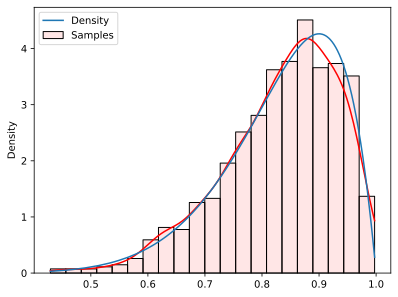

In [ ]:
sns.histplot(samples_beta, stat='density', kde=True, color='red', label='Samples', alpha=0.1)
plt.plot(samples_beta, probs, label='Density')
plt.legend()
plt.show()

Внутри модуля реализован автоматический подсчет KL-дивергенции между двумя произвольными распределениями из одного семейства. Если быть точнее, то между двумя распределениями из экспоненциального класса, но подробнее об этом и формуле вы узнаете на курсе "Байесовских методов". К таким распределениям относятся: нормальное, гамма, бета, Бернулли, экспоненциальное, Дирихле и другие. В PyTorch это все распределения, которые наследуются от `torch.distributions.exp_family.ExponentialFamily`.

In [ ]:
from torch.distributions import kl_divergence

Напомним, что $\mathrm{KL}(\mathcal{N}(m_1, \sigma_1) \| \mathcal{N}(m_2, \sigma_2)) = \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} - \frac{1}{2}$.

In [ ]:
mu = torch.tensor([0.])
sigma = torch.tensor([0.1])
dist1 = distributions.Normal(mu, sigma)
dist2 = distributions.Normal(mu + 1, sigma)
dist3 = distributions.Normal(mu, sigma + 1)

kl_divergence(dist1, dist2), kl_divergence(dist2, dist1), kl_divergence(dist1, dist3)

(tensor([50.]), tensor([50.]), tensor([1.9020]))

В некоторых моделях выходом нейросети являются не сами значения, а параметры распределения (например, $\mu$ и $\sigma$ нормального распределения), из которого мы хотим получить сэмпл $z$ и посчитать функцию потерь для него и обновить параметры распределения.

**Проблема:** операция z = random.normal(mu, sigma) &ndash; стохастическая. Через неё нельзя посчитать производную (backprop не знает, как дифференцировать случайность).

**Решение (Reparameterization Trick):** Вынести случайность в сторону. Представим z как:
$$z = \mu + \sigma \cdot \varepsilon, \text{где } \varepsilon \sim \mathcal{N}(0,1).$$

Здесь $\varepsilon$ &ndash; константа во время backward pass, а $\mu$ и $\sigma$ &ndash; параметры, через которые градиент течет спокойно.

Не для всех распределений это возможно и не всегда сделать такую замену очевидно, но для всех известных стандартных распределений уже всё реализовано.

In [ ]:
mu = torch.tensor([5.0], requires_grad=True)
sigma = torch.tensor([2.0], requires_grad=True)

dist = distributions.Normal(mu, sigma)

print("--- Попытка 1: .sample() ---")
z = dist.sample()
loss = z ** 2
try:
    loss.backward()
except RuntimeError as e:
    print(f"Ошибка: {e}")
    print("Градиенты не текут, так как sample() не дифференцируем.")

print("\n--- Попытка 2: .rsample() ---")
# Reparameterized sample
# Pytorch под капотом делает: z = mu + sigma * epsilon
z = dist.rsample()
loss = (z - 10) ** 2 # Допустим, хотим сдвинуть к 10
loss.backward()

print(f"Сэмпл: {z.item()}")
print(f"Градиент по mu: {mu.grad.item()}")
print(f"Градиент по sigma: {sigma.grad.item()}")

--- Попытка 1: .sample() ---
Ошибка: element 0 of tensors does not require grad and does not have a grad_fn
Градиенты не текут, так как sample() не дифференцируем.

--- Попытка 2: .rsample() ---
Сэмпл: 2.7372636795043945
Градиент по mu: -14.525472640991211
Градиент по sigma: 16.433656692504883


Кроме того, реализованы методы сэмплирования в случае замены переменной. Если у вас есть исходное базовое распределение и вы применили к нему преобразование, то можно использовать класс `TransformedDistribution`. Если функция биективная, то автоматически вы можете считать и логарифм правдоподобия.

\begin{align}
&X \sim \mathrm{BaseDistribution} \\
&Y = f(X) \sim \mathrm{TransformedDistribution}(\mathrm{BaseDistribution}, f) \\
&\log p(Y) = \log p(X) + \log |\mathrm{det} (\mathrm{d}X/\mathrm{d}Y)| \\
\end{align}

Вы также можете объявлять собственные преобразования, главное реализовать всё необходимое: обратная функция, якобиан перехода.

In [ ]:
import torch.distributions.transforms as transforms

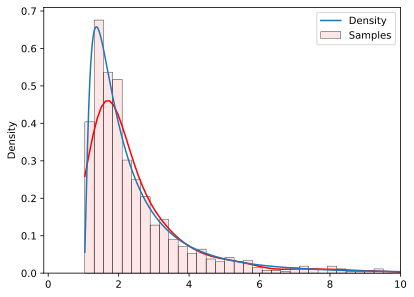

In [ ]:
mu = torch.tensor([0.0])
sigma = torch.tensor([1.0])

base_dist = distributions.Normal(mu, sigma)
f = transforms.ComposeTransform([transforms.ExpTransform(), transforms.AffineTransform(loc=1, scale=1)])
dist = distributions.TransformedDistribution(base_dist, f)
samples = dist.sample((1000, ))

samples = samples.ravel()
samples = torch.sort(samples)[0]
probs = dist.log_prob(samples).exp()

sns.histplot(samples, stat='density', kde=True, color='red', label='Samples', alpha=0.1)
plt.plot(samples, probs, label='Density')

plt.xlim(right=10)
plt.legend()
plt.show()

## Forward-mode Automatic Differentiation

Как мы разбирали на лекции, существует Forward AD, которое не так распространено в нейронных сетях, но может быть полезно для подсчета производных, когда выходов больше, чем входов, что может быть полезно в некоторых ситуациях. В PyTorch есть поддержка этого способа дифференцирования через Jacobian-vector product. Интерфейс очень похож на `.grad()`, однако требует задавать направление, вдоль которого требуется найти производную (`tangent` вектор или vector в `Jacobian-vector product`)

In [ ]:
from torch.autograd.functional import jvp


def function(x):
    return x ** 2

x = torch.tensor([2.0], requires_grad=True)

tangent = torch.tensor([1.0])

y, jvp_value = jvp(function, (x,), (tangent,))

print("Значение функции:", y)
print("Производная (JVP):", jvp_value)

Значение функции: tensor([4.])
Производная (JVP): tensor([4.])


In [ ]:
def function(x):
    a = torch.tensor([1, 2], device=x.device, dtype=x.dtype)
    return x * a

x = torch.tensor([2.0], requires_grad=True)

tangent = torch.tensor([1.0])

y, jvp_value = jvp(function, (x,), (tangent,))

print("Значение функции:", y)
print("Производная (JVP):", jvp_value)

Значение функции: tensor([2., 4.])
Производная (JVP): tensor([1., 2.])


In [ ]:
def function(x):
    return x[0]**2 + x[1]**3

x = torch.tensor([2.0, 3.0], requires_grad=True)

tangent = torch.tensor([1.0, 0.0])

y, vjp_value = jvp(function, (x,), (tangent,))

print("Значение функции:", y)
print("Производная (JVP) в направлении v:", vjp_value)

Значение функции: tensor(31.)
Производная (JVP) в направлении v: tensor(4.)


In [ ]:
def function(x):
    return x[0]**2 + x[1]**3

x = torch.tensor([2.0, 3.0], requires_grad=True)

tangent = torch.tensor([0.0, 1.0])

y, vjp_value = jvp(function, (x,), (tangent,))

print("Значение функции:", y)
print("Производная (JVP) в направлении v:", vjp_value)

Значение функции: tensor(31.)
Производная (JVP) в направлении v: tensor(27.)


In [ ]:
def function(x):
    return x[0]**2 + x[1]**3

x = torch.tensor([2.0, 3.0], requires_grad=True)

tangent = torch.tensor([1.0, 1.0])

y, vjp_value = jvp(function, (x,), (tangent,))

print("Значение функции:", y)
print("Производная (JVP) в направлении v:", vjp_value)

Значение функции: tensor(31.)
Производная (JVP) в направлении v: tensor(31.)


## Некоторые подводные камни

### Иногда broadcasting это зло

Сейчас мы рассмотрим довольно распространенную ошибку при обучении моделей с кастомным лоссом. Библиотечные реализации сообщают о том, что вы, вероятно, делаете не то, что хотите, но иногда приходится пользоваться не только ими. Более того, такая ошибка может выстрелить в самый неожиданный момент. Типичная история:

In [ ]:
W = torch.randn((10, 1), requires_grad=True) # последний слой нейросети, размерность на выходе должна быть 1
x = torch.randn((20, 10)) # входные данные (batch_size, dim)
y = torch.randn(20) # таргеты
preds = x @ W
loss = torch.linalg.norm(preds - y)

А теперь смотрим внимательнее:

In [ ]:
W = torch.randn((10, 1), requires_grad=True) # последний слой нейросети, размерность на выходе должна быть 1
x = torch.randn((20, 10)) # входные данные (batch_size, dim)
y = torch.randn(20) # таргеты
preds = x @ W
print(f'Predictions shape: {preds.shape}')
diff = preds - y
print(f'Difference shape: {diff.shape}')
loss = torch.linalg.norm(diff)

Predictions shape: torch.Size([20, 1])
Difference shape: torch.Size([20, 20])


Пу-пу-пу, сейчас бы обучились... К счастью, это фиксится легко, нужно просто помнить, какую задачу вы решаете и понимать, какая размерность должна быть на выходе

In [ ]:
W = torch.randn((10, 1), requires_grad=True) # последний слой нейросети, размерность на выходе должна быть 1
x = torch.randn((20, 10)) # входные данные (batch_size, dim)
y = torch.randn(20) # таргеты
preds = x @ W
preds = preds.flatten()
print(f'Predictions shape: {preds.shape}')
diff = preds - y
print(f'Difference shape: {diff.shape}')
loss = torch.linalg.norm(diff)

Predictions shape: torch.Size([20])
Difference shape: torch.Size([20])


### Аккуратнее с флотами

In [ ]:
x = torch.randn(1, 3, 10, 10)
x[0, 0, 0, 0] = torch.log(torch.tensor([-1.])) # -1 могла придти откуда угодно

m = torch.nn.Conv2d(3, 6, 3, 1, 1)
output = m(x)
print(output[0, 0, 0:3, 0:3])

tensor([[    nan,     nan, -0.8615],
        [    nan,     nan, -0.1803],
        [ 0.0379, -0.9641, -1.1528]], grad_fn=<SliceBackward0>)


In [ ]:
loss = output.sum()
loss.backward()

Оно не упало, не выругалось, а посчитало градиенты с nan. А это значит, что ваше обучение развалится

In [ ]:
print(f'Количество nan в градиенте: {torch.isnan(m.weight.grad).sum().item()}')

Количество nan в градиенте: 24


Рассмотрим типичные ситуации возникновения нанов/инфов и прочих неприятных персонажей

In [ ]:
x = torch.tensor([0.0], requires_grad=True) # 0 тут пришел откуда-то до, где все логично!
y = 1.0 / x
y.backward()
print(x.grad)

tensor([-inf])


In [ ]:
x = torch.tensor([0.0], requires_grad=True)
y = torch.log(x)
y.backward()
print(x.grad)

tensor([inf])


In [ ]:
x = torch.tensor([1000.0], requires_grad=True)
y = torch.exp(x)
y.backward()
print(x.grad)

tensor([inf])


In [ ]:
print(x.grad + torch.inf)

tensor([inf])


### Как положить кластер

In [ ]:
x = torch.randn([1000, 3, 100, 100])

In [ ]:
torch.save(x, 'full.pt')

In [ ]:
!ls full.pt -lh

-rw-r--r-- 1 root root 115M Feb 17 14:25 full.pt


In [ ]:
torch.save(x[0], 'sample.pt')

In [ ]:
!ls sample.pt -lh

-rw-r--r-- 1 root root 115M Feb 17 14:25 sample.pt


Но подождите, мы же сохраняли всего одну картинку... Как так вышло? Индексация создала view на тензор, а не действительно скопировала ее. То есть мы все еще сохраняли все картинки

In [ ]:
torch.save(x[0].clone(), 'real_sample.pt')

In [ ]:
!ls real_sample.pt -lh

-rw-r--r-- 1 root root 119K Feb 17 14:26 real_sample.pt


А теперь представьте, что мы учим какую-то модельку, и решили изучить, как меняются активации от итерации. Для этого каждый раз мы сохраняем всего одну картинку. Написали сохранение, запустили, оно даже работает, радостно пошли спать. А утром нас ждет сюрприз